# Analysis of the model parameters estimate III
Here we show the contribution of individual components in the MEM using heatmaps. 

In [1]:
## call python script to load data and column order
exec(open('data_file.py').read())

# load packages 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pltx
import seaborn as sns
import pystan
import pickle
import scipy.cluster.hierarchy as sch
import copy
import vb_stan as vbfun
import sub_fun as sf
from matplotlib.backends.backend_pdf import PdfPages
figfol = 'mem_plot/'

plt.rcParams.update(plt.rcParamsDefault)

params = {'legend.fontsize': 12,
          'font.weight': 'bold',
         'axes.labelsize': 12,
         'axes.titlesize':12,
         'axes.labelweight': 'bold',
         'xtick.labelsize':12,
          'axes.titleweight': 'bold',
         #'figure.figsize': (15,8),
          'figure.dpi': 200,
         'ytick.labelsize':12}
plt.rcParams.update(params)

%matplotlib inline

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [2]:
# Call the output from the fitted model:
fname_best = '66_model_nb_cvtest.pkl'
folname = 'MMSens/'
[holdout_mask, llpd, n_test, l,m_seed,sp_mean,\
 sp_var, h_prop, uid, nsample_o, Yte_fit, cv_test] = pickle.load(open(folname + fname_best, "rb"))

# -------------------------------------------------
# save model output 
fname_ot = folname + str(uid) + '_' + 'model_nb.pkl' 
#with open(fname_o, 'wb') as f:
#    pickle.dump(NB_vb, f)
with open(fname_ot, 'rb') as f:
    results = pickle.load(f)
    
sample_fname = folname + str(uid) + '_' + 'sample_model_nb_cvtest.pkl' 
with open(sample_fname, 'rb') as f:
    [Yte_sample,Yte_cv] = pickle.load(f)

parma_mean  = dict(vbfun.vb_extract_mean(results))

/mnt/home/amishra/jobs/microbiome/embeddings/vb_stan.py:57: RuntimeWarning: invalid value encountered in multiply
  params = OrderedDict([(name, np.nan * np.empty(shape)) for name, shape in param_shapes.items()])


In [3]:
## Get mean estimate of the MEM  
muest = np.zeros((n,q))
muest1 = np.zeros((n,q))
for i in range(n):
    for j in range(q):
        muest[i,j] =  parma_mean['C0'][j] + \
            np.matmul(X[i,],parma_mean['C_geo'][j,:]) + \
            np.matmul(S[i,],np.matmul(parma_mean['A_s'],parma_mean['L_sp'][j,:])) + \
            np.matmul(B[i,],np.matmul(parma_mean['A_b'],parma_mean['L_sp'][j,:]));
            #np.matmul(Q[i,],np.matmul(parma_mean['A_m'],parma_mean['L_sp'][j,:])) + \
        if Yi[i,j] == 1:
            temp = copy.copy(Yi[i,:]);temp[j] = 0;
            muest1[i,j] = np.matmul( parma_mean['L_i'][j,:], np.matmul(parma_mean['L_sp'].T,temp))/(Bs[i]-1.0); 
            muest[i,j] = muest[i,j] + muest1[i,j];
        muest[i,j] =  T_i[i]*np.exp(muest[i,j]* parma_mean['tau'][j])


In [4]:
## Extract annotation of the microbial species 
tax_name = pd.read_csv('species_tax.csv')
tax_name = tax_name.rename(columns={'Unnamed: 0': 'OTU'})
tax_name = tax_name[1:]
tax_name.insert(0, 'Id', tax_name['OTU'].str[3:])
tax_name.columns.values[1] = 'Label'
tax_name.to_csv('node_otu.csv', index = False) 
temx = tax_name.iloc[:,:8]
temx = temx.replace(np.nan,'')
species_name = []
# Add taxonomy identifier to the each of the species name 
for i in range(temx.shape[0]):
    a = temx.iloc[i,:].values
    for j in range(a.shape[0]-1,-1,-1):
        if len(a[j]) > 0:
            species_name.append(temx.columns[j][0].lower()+'_'+ a[j])
            break;           
species_name = np.array(species_name)  
tax_name['Name'] = species_name
# tax_name['ord_abu'] = np.linspace(10,1,tax_name.shape[0])[(-1*Y.mean(axis=0)).argsort()]
tax_name['Abundance'] = Y.sum(axis=0)
tax_name[['Id']] = tax_name[['Id']].values.astype(np.int64)
tax_name = tax_name.replace(np.nan,'Empty')
tem = pd.read_csv('species_tax_anot.amended.csv').iloc[:,[1,12]]
tax_name = tax_name.merge(tem,on = 'Label')
tax_name = tax_name.rename(columns={"Ecologically_relevant_classification_aggregated": "ECR"})

## Update the new annotation in the
i = 11    # index for ECR variable 
ind_var = tax_name.iloc[:,i].values
vals, counts = np.unique(ind_var, return_counts=True)
tem_ind1 = (-1*counts).argsort()
tem_val = vals[tem_ind1][range(np.min([np.sum(counts > 10),tem_ind1.shape[0]]))]
tmp = np.setdiff1d(np.unique(ind_var), tem_val)
import sub_fun as sf
tmp = sf.return_indices_of_a(tmp, ind_var)
ind_var[tmp] = "Other" 
tax_name.iloc[:,i] = ind_var

tax_nameN = tax_name[['Label','ECR']]
tax_nameN['val'] = c_ord
tax_nameN.iloc[c_ord,2] = range(Y.shape[1])
# ## Add cluster index in the 
comunity2 = pickle.load(open('ERC_community.pkl', 'rb'))
tem = tax_nameN['Label'].map(comunity2) + 1
clust_col = np.array(['red','blue','green','yellow','grey'])[tem.values-1]
tax_nameN['Cluster'] = clust_col
tax_nameN['COMIND'] = tem
tax_nameN = tax_nameN.sort_values(["COMIND", "val"], ascending = (True, False))
v_indexN = [0]+list(np.where(np.diff(tax_nameN.COMIND.values) > 0)[0]) + [Y.shape[1]]
c_ordN = np.array(tax_nameN.index)
# tax_namex = copy.copy(tax_nameN)
# tax_namex['ERC'] = tax_namex['ECR'].map(species_col_dict)

/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/mnt/home/amishra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

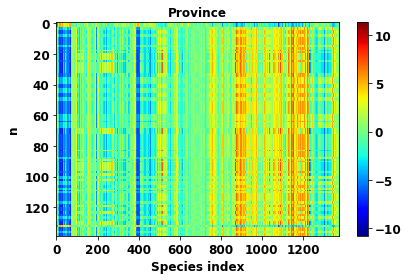

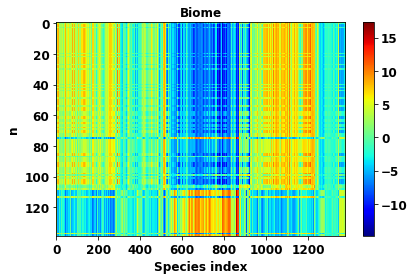

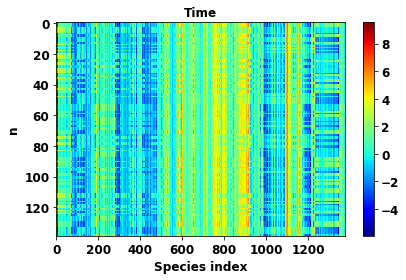

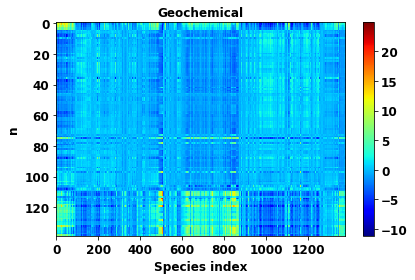

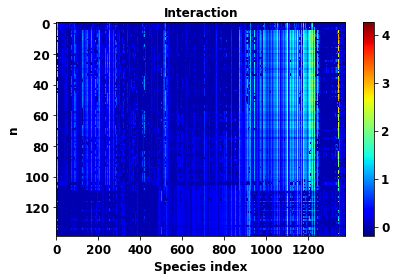

In [5]:
## Contributions of the components of the model 
fnamex = figfol + 'fixed_effect.pdf'
pp = PdfPages(fnamex)
col_ulim = np.log((Y+1).max())

## Region effect: contribution of the spatio temporal locations in the ocean 
tem = np.matmul(S,np.matmul(parma_mean['A_s'],\
                            parma_mean['L_sp'].transpose()))
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Province')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)



## Biome effect: contribution of the Biome/depth 
tem = np.matmul(B,np.matmul(parma_mean['A_b'],\
                            parma_mean['L_sp'].transpose()))
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Biome')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)


## Quarter effect: contribution of the time of the data collection 
tem = np.matmul(Q,np.matmul(parma_mean['A_m'],\
                            parma_mean['L_sp'].transpose()))
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Time')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)


## Geochemical component effect: contribution of the geochemical covariates 
tem = np.matmul(X,parma_mean['C_geo'].transpose())
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Geochemical')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)


## Interaction component effect: contribution of the species-species interaction term 
tem = muest1;
tem = tem[r_ord][:,c_ordN]
fig, ax = plt.subplots()
im = ax.imshow(tem,cmap='jet', aspect='auto')
ax.set_xlabel('Species index')
ax.set_ylabel('n')
ax.set_title('Interaction')
fig.colorbar(im)
fig.tight_layout()
pp.savefig(fig, dpi = 200)


pp.close()